In [1]:
import pandas as pd
from scipy.stats import zscore
import pandas as pd
from sklearn.preprocessing import StandardScaler

# load packages
import pandas as pd
from typing import Optional
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import os

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
# N, D = X_train.shape
from datetime import date
import logging as log
from models.dataset import Dataset as Dataset

from models.utils import add_horizons, normalize

# Configure basic logging to a file
log.basicConfig(
    filename='experiments.log',  # Name of the log file
    level=log.INFO,             # Minimum logging level to capture (e.g., INFO, DEBUG, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s',  # Format of the log messages
    datefmt='%Y-%m-%d %H:%M:%S'      # Format for the timestamp
)

from models.gd import GradientDescent as GradientDescent

In [2]:
tickers=("slv","soxs","gdx","spy")
#tickers=("slv",)
model_shortname="universal"
model_checkpoint_loc="/results/iteration4"
os.makedirs(f".{model_checkpoint_loc}", exist_ok=True)
#0-> 10, 1->50,2->100
horizon_mapping = {
    0: 10,
    1: 50,
    2: 100
}
horizon_to_predict=2
look_back_window=100
batch_size=2048
alpha=0.05
log.info(f"Running model with params Ticker: {tickers} Horizon Idx:{horizon_to_predict} window:{look_back_window} training batch size:{batch_size}")

In [3]:
data_path="data/"
prefix="_cleaned_jan2025"

In [4]:
for ticker in tickers:
    log.info(f"Processing {ticker}")
    print(f"Processing {ticker}")
    dataset_train: Optional[Dataset] = None
    dataset_val: Optional[Dataset] = None
    dataset_test: Optional[Dataset] = None
    df = pd.read_csv(f"{data_path}{ticker}{prefix}.csv",engine="pyarrow",sep = ',')
    df.head()
    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    df["Date-Time"] = df["Date-Time"].dt.tz_convert("America/New_York")
    add_horizons(df,(10, 50, 100),alpha)
    class_summary = df.groupby(f"Target_{horizon_mapping[horizon_to_predict]}").size().reset_index(name="Count")
    # Calculate relative percentage
    class_summary["Percent"] = (class_summary["Count"] / class_summary["Count"].sum()) * 100
    class_summary["Percent"] = class_summary["Percent"].round(2)
    print(class_summary)
    normalize(df)
    df["Date"] = pd.to_datetime(df["Date-Time"]).dt.date
    df.groupby(["Date"]).size()
    df_train = df[(df["Date"] >= date(2025, 1, 3)) & (df["Date"] <= date(2025, 1, 10))]
    df_val = df[(df["Date"] >= date(2025, 1, 25)) & (df["Date"] <= date(2025, 1, 27))]
    df_test = df[(df["Date"] >= date(2025, 1, 28)) & (df["Date"] <= date(2025, 1, 31))]
    target_cols = [f"Target_{i}" for i in [10, 50, 100]]
    price_cols = [f"L{i}-BidPrice" for i in range(1, 11)] + [f"L{i}-AskPrice" for i in range(1, 11)]
    size_cols  = [f"L{i}-BidSize"  for i in range(1, 11)] + [f"L{i}-AskSize"  for i in range(1, 11)]
    df_train = df_train[price_cols + size_cols+target_cols]
    df_test =  df_test[price_cols + size_cols+target_cols]
    df_val = df_val[price_cols + size_cols+target_cols]
    if None in (dataset_train, dataset_val, dataset_test):
        dataset_train = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_val = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_test = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
    else:
        dataset_train1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_val1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_test1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_train.merge(dataset_train1)
        dataset_val.merge(dataset_val1)
        dataset_test.merge(dataset_test1)

Processing slv


   Target_100  Count  Percent
0           0  85644    80.59
1           1  10257     9.65
2           2  10373     9.76


Processing soxs


   Target_100   Count  Percent
0           0  799553    83.22
1           1   81691     8.50
2           2   79561     8.28


Processing gdx


   Target_100   Count  Percent
0           0  298620    88.07
1           1   20087     5.92
2           2   20354     6.00


Processing spy


   Target_100    Count  Percent
0           0  4967012    62.61
1           1  1486493    18.74
2           2  1480263    18.66


In [5]:
for ticker in tickers:
    log.info("Processing {ticker}")
    dataset_train: Optional[Dataset] = None
    dataset_val: Optional[Dataset] = None
    dataset_test: Optional[Dataset] = None
    df = pd.read_csv(f"{data_path}{ticker}{prefix}.csv",engine="pyarrow",sep = ',')
    df.head()
    df["Date-Time"] = pd.to_datetime(df["Date-Time"])
    df["Date-Time"] = df["Date-Time"].dt.tz_convert("America/New_York")
    add_horizons(df,(10, 50, 100),alpha)
    class_summary = df.groupby("Target_100").size().reset_index(name="Count")
    # Calculate relative percentage
    class_summary["Percent"] = (class_summary["Count"] / class_summary["Count"].sum()) * 100
    class_summary["Percent"] = class_summary["Percent"].round(2)
    class_summary
    normalize(df)
    df["Date"] = pd.to_datetime(df["Date-Time"]).dt.date
    df.groupby(["Date"]).size()
    df_train = df[(df["Date"] >= date(2025, 1, 3)) & (df["Date"] <= date(2025, 1, 10))]
    df_val = df[(df["Date"] >= date(2025, 1, 25)) & (df["Date"] <= date(2025, 1, 27))]
    df_test = df[(df["Date"] >= date(2025, 1, 28)) & (df["Date"] <= date(2025, 1, 31))]
    target_cols = [f"Target_{i}" for i in [10, 50, 100]]
    price_cols = [f"L{i}-BidPrice" for i in range(1, 11)] + [f"L{i}-AskPrice" for i in range(1, 11)]
    size_cols  = [f"L{i}-BidSize"  for i in range(1, 11)] + [f"L{i}-AskSize"  for i in range(1, 11)]
    df_train = df_train[price_cols + size_cols+target_cols]
    df_test =  df_test[price_cols + size_cols+target_cols]
    df_val = df_val[price_cols + size_cols+target_cols]
    if None in (dataset_train, dataset_val, dataset_test):
        dataset_train = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_val = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_test = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
    else:
        dataset_train1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_val1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_test1 = Dataset(data=df_train.to_numpy(), k=horizon_to_predict, num_classes=3, T=look_back_window)
        dataset_train.merge(dataset_train1)
        dataset_val.merge(dataset_val1)
        dataset_test.merge(dataset_test1)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

torch.Size([2674610, 1, 100, 40]) torch.Size([2674610])


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [03:30<2:52:17, 210.97s/it]

model saved
Epoch 1/50, Train Loss: 0.9536,               Validation Loss: 0.9474, Duration: 0:03:30.969201, Best Val Epoch: 0


  4%|▍         | 2/50 [07:02<2:49:09, 211.45s/it]

model saved
Epoch 2/50, Train Loss: 0.9465,               Validation Loss: 0.9456, Duration: 0:03:31.779995, Best Val Epoch: 1


  6%|▌         | 3/50 [10:33<2:45:30, 211.28s/it]

model saved
Epoch 3/50, Train Loss: 0.9440,               Validation Loss: 0.9420, Duration: 0:03:31.079638, Best Val Epoch: 2


  8%|▊         | 4/50 [14:04<2:41:44, 210.96s/it]

model saved
Epoch 4/50, Train Loss: 0.9397,               Validation Loss: 0.9383, Duration: 0:03:30.460922, Best Val Epoch: 3


 10%|█         | 5/50 [17:36<2:38:28, 211.29s/it]

model saved
Epoch 5/50, Train Loss: 0.9350,               Validation Loss: 0.9324, Duration: 0:03:31.890406, Best Val Epoch: 4


 12%|█▏        | 6/50 [21:07<2:34:52, 211.18s/it]

model saved
Epoch 6/50, Train Loss: 0.9301,               Validation Loss: 0.9284, Duration: 0:03:30.966695, Best Val Epoch: 5


 14%|█▍        | 7/50 [24:40<2:31:44, 211.73s/it]

model saved
Epoch 7/50, Train Loss: 0.9247,               Validation Loss: 0.9258, Duration: 0:03:32.852628, Best Val Epoch: 6


 16%|█▌        | 8/50 [28:12<2:28:24, 212.02s/it]

model saved
Epoch 8/50, Train Loss: 0.9193,               Validation Loss: 0.9153, Duration: 0:03:32.632178, Best Val Epoch: 7


 18%|█▊        | 9/50 [31:44<2:24:53, 212.03s/it]

model saved
Epoch 9/50, Train Loss: 0.9141,               Validation Loss: 0.9126, Duration: 0:03:32.057179, Best Val Epoch: 8


 20%|██        | 10/50 [35:15<2:21:07, 211.68s/it]

model saved
Epoch 10/50, Train Loss: 0.9097,               Validation Loss: 0.9064, Duration: 0:03:30.878958, Best Val Epoch: 9


 22%|██▏       | 11/50 [38:46<2:17:28, 211.51s/it]

model saved
Epoch 11/50, Train Loss: 0.9057,               Validation Loss: 0.9040, Duration: 0:03:31.119355, Best Val Epoch: 10


 24%|██▍       | 12/50 [42:19<2:14:06, 211.76s/it]

model saved
Epoch 12/50, Train Loss: 0.9019,               Validation Loss: 0.8998, Duration: 0:03:32.346387, Best Val Epoch: 11


 26%|██▌       | 13/50 [45:50<2:10:30, 211.65s/it]

model saved
Epoch 13/50, Train Loss: 0.8986,               Validation Loss: 0.8955, Duration: 0:03:31.376725, Best Val Epoch: 12


 28%|██▊       | 14/50 [49:21<2:06:51, 211.43s/it]

Epoch 14/50, Train Loss: 0.8954,               Validation Loss: 0.8957, Duration: 0:03:30.929472, Best Val Epoch: 12


 30%|███       | 15/50 [52:51<2:03:09, 211.12s/it]

model saved
Epoch 15/50, Train Loss: 0.8924,               Validation Loss: 0.8915, Duration: 0:03:30.399178, Best Val Epoch: 14


 32%|███▏      | 16/50 [56:22<1:59:38, 211.14s/it]

model saved
Epoch 16/50, Train Loss: 0.8890,               Validation Loss: 0.8869, Duration: 0:03:31.181903, Best Val Epoch: 15


 34%|███▍      | 17/50 [59:54<1:56:11, 211.24s/it]

model saved
Epoch 17/50, Train Loss: 0.8859,               Validation Loss: 0.8851, Duration: 0:03:31.485525, Best Val Epoch: 16


 36%|███▌      | 18/50 [1:03:25<1:52:33, 211.05s/it]

model saved
Epoch 18/50, Train Loss: 0.8830,               Validation Loss: 0.8796, Duration: 0:03:30.589898, Best Val Epoch: 17


 38%|███▊      | 19/50 [1:06:55<1:48:55, 210.84s/it]

model saved
Epoch 19/50, Train Loss: 0.8810,               Validation Loss: 0.8776, Duration: 0:03:30.348779, Best Val Epoch: 18


 40%|████      | 20/50 [1:10:29<1:45:51, 211.71s/it]

Epoch 20/50, Train Loss: 0.8782,               Validation Loss: 0.8790, Duration: 0:03:33.726481, Best Val Epoch: 18


 42%|████▏     | 21/50 [1:14:00<1:42:18, 211.66s/it]

model saved
Epoch 21/50, Train Loss: 0.8754,               Validation Loss: 0.8741, Duration: 0:03:31.538724, Best Val Epoch: 20


 44%|████▍     | 22/50 [1:17:32<1:38:46, 211.65s/it]

model saved
Epoch 22/50, Train Loss: 0.8731,               Validation Loss: 0.8721, Duration: 0:03:31.636816, Best Val Epoch: 21


 46%|████▌     | 23/50 [1:21:03<1:35:15, 211.67s/it]

model saved
Epoch 23/50, Train Loss: 0.8705,               Validation Loss: 0.8716, Duration: 0:03:31.708623, Best Val Epoch: 22


 48%|████▊     | 24/50 [1:24:36<1:31:47, 211.82s/it]

model saved
Epoch 24/50, Train Loss: 0.8680,               Validation Loss: 0.8631, Duration: 0:03:32.169152, Best Val Epoch: 23


 50%|█████     | 25/50 [1:28:07<1:28:11, 211.68s/it]

Epoch 25/50, Train Loss: 0.8655,               Validation Loss: 0.8649, Duration: 0:03:31.347296, Best Val Epoch: 23


 52%|█████▏    | 26/50 [1:31:38<1:24:36, 211.51s/it]

model saved
Epoch 26/50, Train Loss: 0.8635,               Validation Loss: 0.8627, Duration: 0:03:31.112730, Best Val Epoch: 25


 54%|█████▍    | 27/50 [1:35:10<1:21:06, 211.59s/it]

model saved
Epoch 27/50, Train Loss: 0.8616,               Validation Loss: 0.8596, Duration: 0:03:31.787982, Best Val Epoch: 26


 56%|█████▌    | 28/50 [1:38:41<1:17:30, 211.37s/it]

model saved
Epoch 28/50, Train Loss: 0.8596,               Validation Loss: 0.8572, Duration: 0:03:30.842812, Best Val Epoch: 27


 58%|█████▊    | 29/50 [1:42:11<1:13:53, 211.13s/it]

model saved
Epoch 29/50, Train Loss: 0.8574,               Validation Loss: 0.8537, Duration: 0:03:30.560250, Best Val Epoch: 28


 60%|██████    | 30/50 [1:45:42<1:10:22, 211.11s/it]

Epoch 30/50, Train Loss: 0.8544,               Validation Loss: 0.8537, Duration: 0:03:31.062978, Best Val Epoch: 28


 62%|██████▏   | 31/50 [1:49:13<1:06:49, 211.01s/it]

model saved
Epoch 31/50, Train Loss: 0.8524,               Validation Loss: 0.8511, Duration: 0:03:30.785532, Best Val Epoch: 30


 64%|██████▍   | 32/50 [1:52:44<1:03:18, 211.02s/it]

model saved
Epoch 32/50, Train Loss: 0.8517,               Validation Loss: 0.8486, Duration: 0:03:31.046849, Best Val Epoch: 31


 66%|██████▌   | 33/50 [1:56:15<59:47, 211.05s/it]  

Epoch 33/50, Train Loss: 0.8500,               Validation Loss: 0.8522, Duration: 0:03:31.095623, Best Val Epoch: 31


 68%|██████▊   | 34/50 [1:59:45<56:11, 210.69s/it]

model saved
Epoch 34/50, Train Loss: 0.8604,               Validation Loss: 0.8474, Duration: 0:03:29.861241, Best Val Epoch: 33


 70%|███████   | 35/50 [2:03:17<52:45, 211.02s/it]

model saved
Epoch 35/50, Train Loss: 0.8480,               Validation Loss: 0.8454, Duration: 0:03:31.780255, Best Val Epoch: 34


 72%|███████▏  | 36/50 [2:06:49<49:18, 211.34s/it]

model saved
Epoch 36/50, Train Loss: 0.8444,               Validation Loss: 0.8414, Duration: 0:03:32.096008, Best Val Epoch: 35


 74%|███████▍  | 37/50 [2:10:21<45:48, 211.45s/it]

Epoch 37/50, Train Loss: 0.8439,               Validation Loss: 0.8474, Duration: 0:03:31.701683, Best Val Epoch: 35


 76%|███████▌  | 38/50 [2:13:52<42:17, 211.44s/it]

model saved
Epoch 38/50, Train Loss: 0.8421,               Validation Loss: 0.8413, Duration: 0:03:31.409307, Best Val Epoch: 37


 78%|███████▊  | 39/50 [2:17:25<38:50, 211.83s/it]

Epoch 39/50, Train Loss: 0.8404,               Validation Loss: 0.8414, Duration: 0:03:32.755175, Best Val Epoch: 37


 80%|████████  | 40/50 [2:20:56<35:14, 211.49s/it]

model saved
Epoch 40/50, Train Loss: 0.8389,               Validation Loss: 0.8362, Duration: 0:03:30.669480, Best Val Epoch: 39


 82%|████████▏ | 41/50 [2:24:26<31:40, 211.11s/it]

model saved
Epoch 41/50, Train Loss: 0.8378,               Validation Loss: 0.8359, Duration: 0:03:30.241910, Best Val Epoch: 40


 84%|████████▍ | 42/50 [2:27:57<28:09, 211.18s/it]

model saved
Epoch 42/50, Train Loss: 0.8363,               Validation Loss: 0.8333, Duration: 0:03:31.347481, Best Val Epoch: 41


 86%|████████▌ | 43/50 [2:31:29<24:39, 211.32s/it]

model saved
Epoch 43/50, Train Loss: 0.8352,               Validation Loss: 0.8304, Duration: 0:03:31.628533, Best Val Epoch: 42


 88%|████████▊ | 44/50 [2:35:01<21:10, 211.67s/it]

Epoch 44/50, Train Loss: 0.8342,               Validation Loss: 0.8304, Duration: 0:03:32.485909, Best Val Epoch: 42


 90%|█████████ | 45/50 [2:38:34<17:39, 211.91s/it]

model saved
Epoch 45/50, Train Loss: 0.8322,               Validation Loss: 0.8281, Duration: 0:03:32.467067, Best Val Epoch: 44


 92%|█████████▏| 46/50 [2:42:07<14:09, 212.40s/it]

model saved
Epoch 46/50, Train Loss: 0.8313,               Validation Loss: 0.8267, Duration: 0:03:33.549706, Best Val Epoch: 45


 94%|█████████▍| 47/50 [2:45:41<10:37, 212.63s/it]

Epoch 47/50, Train Loss: 0.8308,               Validation Loss: 0.8272, Duration: 0:03:33.166187, Best Val Epoch: 45


 96%|█████████▌| 48/50 [2:49:12<07:04, 212.37s/it]

model saved
Epoch 48/50, Train Loss: 0.8304,               Validation Loss: 0.8249, Duration: 0:03:31.749556, Best Val Epoch: 47


 98%|█████████▊| 49/50 [2:52:46<03:32, 212.83s/it]

Epoch 49/50, Train Loss: 0.8270,               Validation Loss: 0.8255, Duration: 0:03:33.894960, Best Val Epoch: 47


100%|██████████| 50/50 [2:56:20<00:00, 213.02s/it]

100%|██████████| 50/50 [2:56:20<00:00, 211.60s/it]

model saved
Epoch 50/50, Train Loss: 0.8262,               Validation Loss: 0.8243, Duration: 0:03:33.481360, Best Val Epoch: 49



/home/nnagara1/DNNLOB1/models/gd.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'.{model_savepoint}')


accuracy_score: 0.7261712922631711


              precision    recall  f1-score   support

           0     0.7025    0.9598    0.8112   1613057
           1     0.8365    0.3684    0.5115    535936
           2     0.8378    0.3740    0.5172    525617

    accuracy                         0.7262   2674610
   macro avg     0.7923    0.5674    0.6133   2674610
weighted avg     0.7559    0.7262    0.6934   2674610



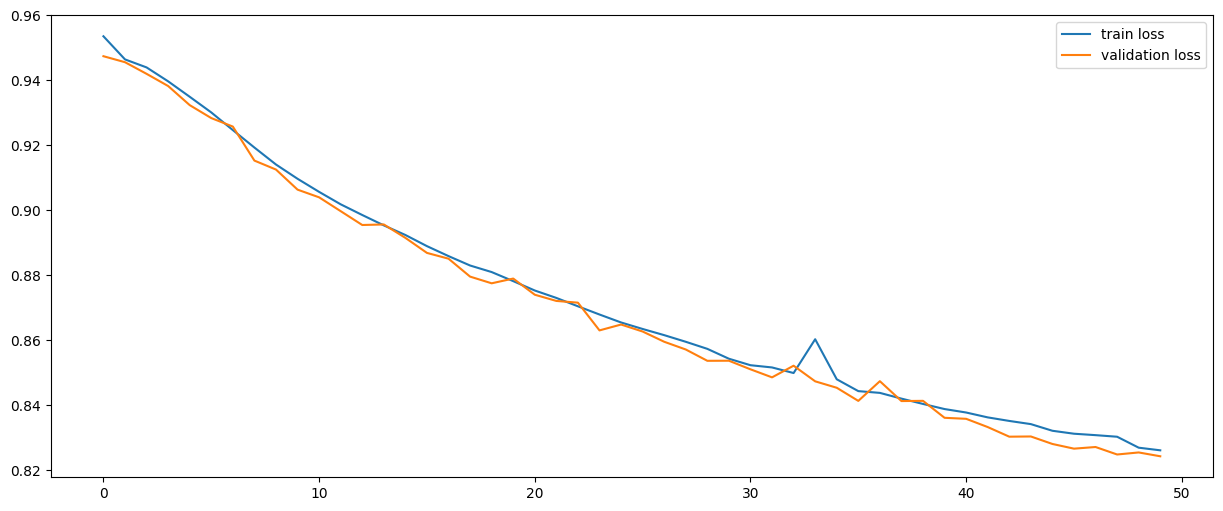

In [8]:
from models.deeplob import deeplob as deeplob
model = deeplob(device=device,y_len = dataset_train.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_deeplob.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
from models.gd import GradientDescent as GradientDescent
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [01:27<1:11:14, 87.23s/it]

model saved
Epoch 1/50, Train Loss: 0.9548,               Validation Loss: 0.9423, Duration: 0:01:27.231636, Best Val Epoch: 0


  4%|▍         | 2/50 [02:52<1:08:58, 86.22s/it]

model saved
Epoch 2/50, Train Loss: 0.9418,               Validation Loss: 0.9412, Duration: 0:01:25.505877, Best Val Epoch: 1


  6%|▌         | 3/50 [04:19<1:07:38, 86.35s/it]

model saved
Epoch 3/50, Train Loss: 0.9406,               Validation Loss: 0.9400, Duration: 0:01:26.503203, Best Val Epoch: 2


  8%|▊         | 4/50 [05:47<1:06:42, 87.00s/it]

model saved
Epoch 4/50, Train Loss: 0.9395,               Validation Loss: 0.9390, Duration: 0:01:27.999046, Best Val Epoch: 3


 10%|█         | 5/50 [07:11<1:04:33, 86.08s/it]

model saved
Epoch 5/50, Train Loss: 0.9384,               Validation Loss: 0.9378, Duration: 0:01:24.447282, Best Val Epoch: 4


 12%|█▏        | 6/50 [08:38<1:03:12, 86.20s/it]

model saved
Epoch 6/50, Train Loss: 0.9373,               Validation Loss: 0.9366, Duration: 0:01:26.441112, Best Val Epoch: 5


 14%|█▍        | 7/50 [10:03<1:01:40, 86.07s/it]

model saved
Epoch 7/50, Train Loss: 0.9362,               Validation Loss: 0.9355, Duration: 0:01:25.784445, Best Val Epoch: 6


 16%|█▌        | 8/50 [11:31<1:00:29, 86.42s/it]

model saved
Epoch 8/50, Train Loss: 0.9352,               Validation Loss: 0.9354, Duration: 0:01:27.174313, Best Val Epoch: 7


 18%|█▊        | 9/50 [12:56<58:45, 86.00s/it]  

model saved
Epoch 9/50, Train Loss: 0.9342,               Validation Loss: 0.9335, Duration: 0:01:25.073647, Best Val Epoch: 8


 20%|██        | 10/50 [14:24<57:51, 86.78s/it]

model saved
Epoch 10/50, Train Loss: 0.9331,               Validation Loss: 0.9324, Duration: 0:01:28.526890, Best Val Epoch: 9


 22%|██▏       | 11/50 [15:49<56:06, 86.33s/it]

model saved
Epoch 11/50, Train Loss: 0.9320,               Validation Loss: 0.9318, Duration: 0:01:25.294534, Best Val Epoch: 10


 24%|██▍       | 12/50 [17:18<55:05, 86.98s/it]

model saved
Epoch 12/50, Train Loss: 0.9309,               Validation Loss: 0.9304, Duration: 0:01:28.476515, Best Val Epoch: 11


 26%|██▌       | 13/50 [18:42<53:06, 86.13s/it]

model saved
Epoch 13/50, Train Loss: 0.9299,               Validation Loss: 0.9298, Duration: 0:01:24.181328, Best Val Epoch: 12


 28%|██▊       | 14/50 [20:11<52:05, 86.83s/it]

model saved
Epoch 14/50, Train Loss: 0.9288,               Validation Loss: 0.9280, Duration: 0:01:28.426726, Best Val Epoch: 13


 30%|███       | 15/50 [21:37<50:39, 86.83s/it]

model saved
Epoch 15/50, Train Loss: 0.9279,               Validation Loss: 0.9272, Duration: 0:01:26.842836, Best Val Epoch: 14


 32%|███▏      | 16/50 [23:04<49:14, 86.88s/it]

model saved
Epoch 16/50, Train Loss: 0.9269,               Validation Loss: 0.9263, Duration: 0:01:27.002225, Best Val Epoch: 15


 34%|███▍      | 17/50 [24:28<47:18, 86.01s/it]

model saved
Epoch 17/50, Train Loss: 0.9260,               Validation Loss: 0.9247, Duration: 0:01:23.976073, Best Val Epoch: 16


 36%|███▌      | 18/50 [25:55<45:58, 86.20s/it]

Epoch 18/50, Train Loss: 0.9249,               Validation Loss: 0.9253, Duration: 0:01:26.630509, Best Val Epoch: 16


 38%|███▊      | 19/50 [27:24<44:53, 86.87s/it]

model saved
Epoch 19/50, Train Loss: 0.9239,               Validation Loss: 0.9238, Duration: 0:01:28.452926, Best Val Epoch: 18


 40%|████      | 20/50 [28:49<43:13, 86.45s/it]

model saved
Epoch 20/50, Train Loss: 0.9229,               Validation Loss: 0.9219, Duration: 0:01:25.474087, Best Val Epoch: 19


 42%|████▏     | 21/50 [30:16<41:48, 86.51s/it]

Epoch 21/50, Train Loss: 0.9219,               Validation Loss: 0.9221, Duration: 0:01:26.642672, Best Val Epoch: 19


 44%|████▍     | 22/50 [31:41<40:15, 86.26s/it]

model saved
Epoch 22/50, Train Loss: 0.9212,               Validation Loss: 0.9204, Duration: 0:01:25.666679, Best Val Epoch: 21


 46%|████▌     | 23/50 [33:05<38:28, 85.49s/it]

model saved
Epoch 23/50, Train Loss: 0.9202,               Validation Loss: 0.9197, Duration: 0:01:23.679906, Best Val Epoch: 22


 48%|████▊     | 24/50 [34:32<37:17, 86.07s/it]

model saved
Epoch 24/50, Train Loss: 0.9193,               Validation Loss: 0.9191, Duration: 0:01:27.431352, Best Val Epoch: 23


 50%|█████     | 25/50 [35:58<35:50, 86.01s/it]

model saved
Epoch 25/50, Train Loss: 0.9184,               Validation Loss: 0.9182, Duration: 0:01:25.883343, Best Val Epoch: 24


 52%|█████▏    | 26/50 [37:26<34:34, 86.46s/it]

model saved
Epoch 26/50, Train Loss: 0.9176,               Validation Loss: 0.9173, Duration: 0:01:27.491816, Best Val Epoch: 25


 54%|█████▍    | 27/50 [38:51<33:00, 86.11s/it]

model saved
Epoch 27/50, Train Loss: 0.9169,               Validation Loss: 0.9163, Duration: 0:01:25.302817, Best Val Epoch: 26


 56%|█████▌    | 28/50 [40:18<31:39, 86.34s/it]

Epoch 28/50, Train Loss: 0.9160,               Validation Loss: 0.9179, Duration: 0:01:26.884073, Best Val Epoch: 26


 58%|█████▊    | 29/50 [41:46<30:23, 86.86s/it]

model saved
Epoch 29/50, Train Loss: 0.9152,               Validation Loss: 0.9157, Duration: 0:01:28.047594, Best Val Epoch: 28


 60%|██████    | 30/50 [43:13<28:57, 86.90s/it]

model saved
Epoch 30/50, Train Loss: 0.9144,               Validation Loss: 0.9139, Duration: 0:01:26.994183, Best Val Epoch: 29


 62%|██████▏   | 31/50 [44:40<27:33, 87.05s/it]

model saved
Epoch 31/50, Train Loss: 0.9136,               Validation Loss: 0.9126, Duration: 0:01:27.392552, Best Val Epoch: 30


 64%|██████▍   | 32/50 [46:07<26:03, 86.87s/it]

model saved
Epoch 32/50, Train Loss: 0.9128,               Validation Loss: 0.9125, Duration: 0:01:26.456400, Best Val Epoch: 31


 66%|██████▌   | 33/50 [47:35<24:41, 87.13s/it]

model saved
Epoch 33/50, Train Loss: 0.9120,               Validation Loss: 0.9109, Duration: 0:01:27.722141, Best Val Epoch: 32


 68%|██████▊   | 34/50 [49:00<23:05, 86.58s/it]

Epoch 34/50, Train Loss: 0.9113,               Validation Loss: 0.9110, Duration: 0:01:25.287962, Best Val Epoch: 32


 70%|███████   | 35/50 [50:25<21:33, 86.25s/it]

model saved
Epoch 35/50, Train Loss: 0.9106,               Validation Loss: 0.9093, Duration: 0:01:25.474442, Best Val Epoch: 34


 72%|███████▏  | 36/50 [51:54<20:15, 86.84s/it]

model saved
Epoch 36/50, Train Loss: 0.9098,               Validation Loss: 0.9089, Duration: 0:01:28.216203, Best Val Epoch: 35


 74%|███████▍  | 37/50 [53:19<18:44, 86.49s/it]

model saved
Epoch 37/50, Train Loss: 0.9090,               Validation Loss: 0.9085, Duration: 0:01:25.667677, Best Val Epoch: 36


 76%|███████▌  | 38/50 [54:47<17:23, 86.93s/it]

model saved
Epoch 38/50, Train Loss: 0.9083,               Validation Loss: 0.9082, Duration: 0:01:27.967654, Best Val Epoch: 37


 78%|███████▊  | 39/50 [56:12<15:49, 86.33s/it]

model saved
Epoch 39/50, Train Loss: 0.9076,               Validation Loss: 0.9066, Duration: 0:01:24.920029, Best Val Epoch: 38


 80%|████████  | 40/50 [57:40<14:28, 86.86s/it]

Epoch 40/50, Train Loss: 0.9070,               Validation Loss: 0.9067, Duration: 0:01:28.090211, Best Val Epoch: 38


 82%|████████▏ | 41/50 [59:09<13:07, 87.49s/it]

Epoch 41/50, Train Loss: 0.9063,               Validation Loss: 0.9084, Duration: 0:01:28.977058, Best Val Epoch: 38


 84%|████████▍ | 42/50 [1:00:35<11:35, 86.93s/it]

model saved
Epoch 42/50, Train Loss: 0.9055,               Validation Loss: 0.9048, Duration: 0:01:25.595880, Best Val Epoch: 41


 86%|████████▌ | 43/50 [1:02:01<10:06, 86.69s/it]

Epoch 43/50, Train Loss: 0.9050,               Validation Loss: 0.9056, Duration: 0:01:26.139027, Best Val Epoch: 41


 88%|████████▊ | 44/50 [1:03:29<08:41, 87.00s/it]

model saved
Epoch 44/50, Train Loss: 0.9042,               Validation Loss: 0.9043, Duration: 0:01:27.716071, Best Val Epoch: 43


 90%|█████████ | 45/50 [1:04:55<07:13, 86.71s/it]

model saved
Epoch 45/50, Train Loss: 0.9036,               Validation Loss: 0.9038, Duration: 0:01:26.028760, Best Val Epoch: 44


 92%|█████████▏| 46/50 [1:06:20<05:45, 86.32s/it]

model saved
Epoch 46/50, Train Loss: 0.9030,               Validation Loss: 0.9034, Duration: 0:01:25.421708, Best Val Epoch: 45


 94%|█████████▍| 47/50 [1:07:47<04:19, 86.51s/it]

model saved
Epoch 47/50, Train Loss: 0.9023,               Validation Loss: 0.9021, Duration: 0:01:26.944121, Best Val Epoch: 46


 96%|█████████▌| 48/50 [1:09:11<02:51, 85.82s/it]

model saved
Epoch 48/50, Train Loss: 0.9017,               Validation Loss: 0.9021, Duration: 0:01:24.212788, Best Val Epoch: 47


 98%|█████████▊| 49/50 [1:10:39<01:26, 86.35s/it]

model saved
Epoch 49/50, Train Loss: 0.9011,               Validation Loss: 0.8999, Duration: 0:01:27.589189, Best Val Epoch: 48


100%|██████████| 50/50 [1:12:04<00:00, 86.11s/it]

100%|██████████| 50/50 [1:12:04<00:00, 86.50s/it]

model saved
Epoch 50/50, Train Loss: 0.9005,               Validation Loss: 0.8992, Duration: 0:01:25.555762, Best Val Epoch: 49



/home/nnagara1/DNNLOB1/models/gd.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'.{model_savepoint}')


accuracy_score: 0.6148638493088712


              precision    recall  f1-score   support

           0     0.6156    0.9782    0.7557   1613057
           1     0.6344    0.0513    0.0948    535936
           2     0.5735    0.0744    0.1317    525617

    accuracy                         0.6149   2674610
   macro avg     0.6078    0.3680    0.3274   2674610
weighted avg     0.6111    0.6149    0.5006   2674610



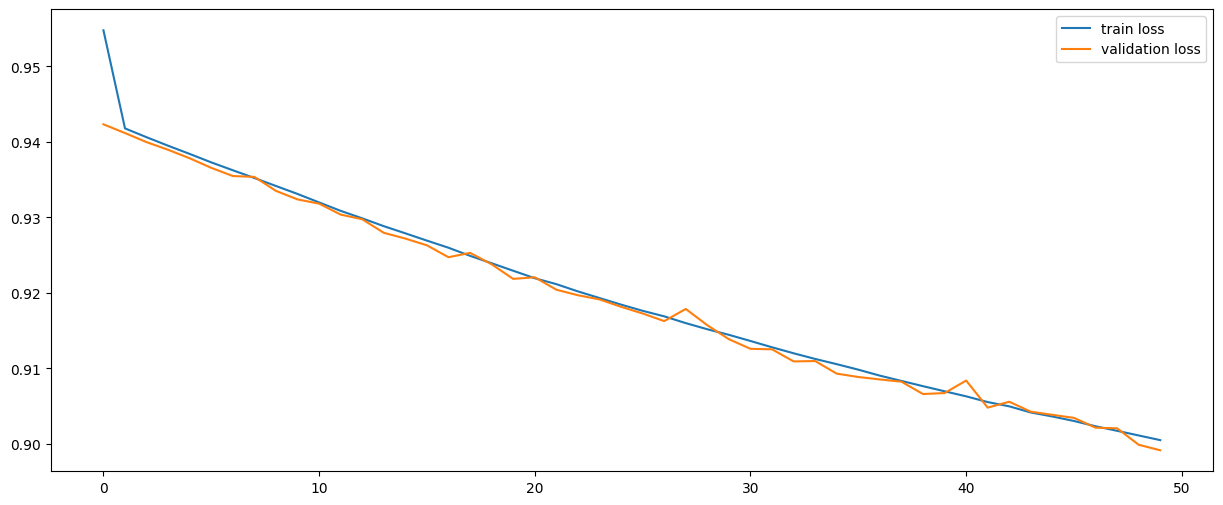

In [9]:
from models.cnn1 import CNN1

model = CNN1(num_classes = dataset_train.num_classes)
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_cnn1.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [01:37<1:19:33, 97.42s/it]

model saved
Epoch 1/50, Train Loss: 0.9677,               Validation Loss: 0.9626, Duration: 0:01:37.422522, Best Val Epoch: 0


  4%|▍         | 2/50 [03:53<1:36:14, 120.31s/it]

model saved
Epoch 2/50, Train Loss: 0.9619,               Validation Loss: 0.9601, Duration: 0:02:16.328566, Best Val Epoch: 1


  6%|▌         | 3/50 [06:06<1:38:46, 126.10s/it]

model saved
Epoch 3/50, Train Loss: 0.9541,               Validation Loss: 0.9480, Duration: 0:02:12.983354, Best Val Epoch: 2


  8%|▊         | 4/50 [07:51<1:30:14, 117.71s/it]

model saved
Epoch 4/50, Train Loss: 0.9481,               Validation Loss: 0.9477, Duration: 0:01:44.839433, Best Val Epoch: 3


 10%|█         | 5/50 [10:00<1:31:25, 121.90s/it]

model saved
Epoch 5/50, Train Loss: 0.9480,               Validation Loss: 0.9476, Duration: 0:02:09.345320, Best Val Epoch: 4


 12%|█▏        | 6/50 [12:07<1:30:39, 123.62s/it]

model saved
Epoch 6/50, Train Loss: 0.9479,               Validation Loss: 0.9476, Duration: 0:02:06.959078, Best Val Epoch: 5


 14%|█▍        | 7/50 [13:29<1:18:49, 109.99s/it]

Epoch 7/50, Train Loss: 0.9478,               Validation Loss: 0.9477, Duration: 0:01:21.929072, Best Val Epoch: 5


 16%|█▌        | 8/50 [15:14<1:15:54, 108.45s/it]

model saved
Epoch 8/50, Train Loss: 0.9477,               Validation Loss: 0.9475, Duration: 0:01:45.137715, Best Val Epoch: 7


 18%|█▊        | 9/50 [17:27<1:19:09, 115.83s/it]

Epoch 9/50, Train Loss: 0.9477,               Validation Loss: 0.9480, Duration: 0:02:12.065304, Best Val Epoch: 7


 20%|██        | 10/50 [19:36<1:20:04, 120.12s/it]

Epoch 10/50, Train Loss: 0.9477,               Validation Loss: 0.9476, Duration: 0:02:09.711954, Best Val Epoch: 7


 22%|██▏       | 11/50 [21:26<1:16:00, 116.94s/it]

Epoch 11/50, Train Loss: 0.9476,               Validation Loss: 0.9476, Duration: 0:01:49.745432, Best Val Epoch: 7


 24%|██▍       | 12/50 [23:07<1:10:56, 112.02s/it]

Epoch 12/50, Train Loss: 0.9476,               Validation Loss: 0.9476, Duration: 0:01:40.770287, Best Val Epoch: 7


 26%|██▌       | 13/50 [25:25<1:14:01, 120.04s/it]

model saved
Epoch 13/50, Train Loss: 0.9475,               Validation Loss: 0.9473, Duration: 0:02:18.490204, Best Val Epoch: 12


 28%|██▊       | 14/50 [27:42<1:15:02, 125.06s/it]

Epoch 14/50, Train Loss: 0.9475,               Validation Loss: 0.9474, Duration: 0:02:16.651826, Best Val Epoch: 12


 30%|███       | 15/50 [29:25<1:09:03, 118.39s/it]

Epoch 15/50, Train Loss: 0.9475,               Validation Loss: 0.9477, Duration: 0:01:42.935874, Best Val Epoch: 12


 32%|███▏      | 16/50 [31:37<1:09:22, 122.41s/it]

model saved
Epoch 16/50, Train Loss: 0.9475,               Validation Loss: 0.9472, Duration: 0:02:11.752112, Best Val Epoch: 15


 34%|███▍      | 17/50 [33:57<1:10:21, 127.94s/it]

model saved
Epoch 17/50, Train Loss: 0.9474,               Validation Loss: 0.9472, Duration: 0:02:20.775027, Best Val Epoch: 16


 36%|███▌      | 18/50 [35:48<1:05:22, 122.59s/it]

model saved
Epoch 18/50, Train Loss: 0.9474,               Validation Loss: 0.9471, Duration: 0:01:50.140080, Best Val Epoch: 17


 38%|███▊      | 19/50 [37:13<57:33, 111.40s/it]  

Epoch 19/50, Train Loss: 0.9474,               Validation Loss: 0.9477, Duration: 0:01:25.335800, Best Val Epoch: 17


 40%|████      | 20/50 [39:29<59:24, 118.81s/it]

model saved
Epoch 20/50, Train Loss: 0.9474,               Validation Loss: 0.9470, Duration: 0:02:16.073504, Best Val Epoch: 19


 42%|████▏     | 21/50 [41:44<59:45, 123.63s/it]

Epoch 21/50, Train Loss: 0.9474,               Validation Loss: 0.9471, Duration: 0:02:14.874366, Best Val Epoch: 19


 44%|████▍     | 22/50 [43:50<58:03, 124.40s/it]

Epoch 22/50, Train Loss: 0.9473,               Validation Loss: 0.9472, Duration: 0:02:06.174118, Best Val Epoch: 19


 46%|████▌     | 23/50 [45:36<53:29, 118.88s/it]

model saved
Epoch 23/50, Train Loss: 0.9473,               Validation Loss: 0.9470, Duration: 0:01:46.006459, Best Val Epoch: 22


 48%|████▊     | 24/50 [47:01<47:03, 108.61s/it]

model saved
Epoch 24/50, Train Loss: 0.9473,               Validation Loss: 0.9470, Duration: 0:01:24.644707, Best Val Epoch: 23


 50%|█████     | 25/50 [48:45<44:46, 107.47s/it]

model saved
Epoch 25/50, Train Loss: 0.9472,               Validation Loss: 0.9470, Duration: 0:01:44.818271, Best Val Epoch: 24


 52%|█████▏    | 26/50 [50:31<42:45, 106.89s/it]

Epoch 26/50, Train Loss: 0.9472,               Validation Loss: 0.9475, Duration: 0:01:45.536228, Best Val Epoch: 24


 54%|█████▍    | 27/50 [52:37<43:09, 112.57s/it]

Epoch 27/50, Train Loss: 0.9472,               Validation Loss: 0.9470, Duration: 0:02:05.819966, Best Val Epoch: 24


 56%|█████▌    | 28/50 [54:23<40:35, 110.73s/it]

model saved
Epoch 28/50, Train Loss: 0.9471,               Validation Loss: 0.9470, Duration: 0:01:46.423475, Best Val Epoch: 27


 58%|█████▊    | 29/50 [56:14<38:46, 110.81s/it]

model saved
Epoch 29/50, Train Loss: 0.9471,               Validation Loss: 0.9469, Duration: 0:01:50.988419, Best Val Epoch: 28


 60%|██████    | 30/50 [58:35<39:58, 119.94s/it]

Epoch 30/50, Train Loss: 0.9471,               Validation Loss: 0.9470, Duration: 0:02:21.252119, Best Val Epoch: 28


 62%|██████▏   | 31/50 [1:00:24<36:53, 116.49s/it]

model saved
Epoch 31/50, Train Loss: 0.9471,               Validation Loss: 0.9469, Duration: 0:01:48.449789, Best Val Epoch: 30


 64%|██████▍   | 32/50 [1:01:46<31:51, 106.20s/it]

Epoch 32/50, Train Loss: 0.9471,               Validation Loss: 0.9473, Duration: 0:01:22.181756, Best Val Epoch: 30


 66%|██████▌   | 33/50 [1:03:10<28:09, 99.40s/it] 

model saved
Epoch 33/50, Train Loss: 0.9470,               Validation Loss: 0.9468, Duration: 0:01:23.527636, Best Val Epoch: 32


 68%|██████▊   | 34/50 [1:04:55<26:59, 101.19s/it]

Epoch 34/50, Train Loss: 0.9470,               Validation Loss: 0.9469, Duration: 0:01:45.377369, Best Val Epoch: 32


 70%|███████   | 35/50 [1:06:52<26:30, 106.02s/it]

model saved
Epoch 35/50, Train Loss: 0.9470,               Validation Loss: 0.9468, Duration: 0:01:57.285130, Best Val Epoch: 34


 72%|███████▏  | 36/50 [1:08:38<24:42, 105.88s/it]

model saved
Epoch 36/50, Train Loss: 0.9471,               Validation Loss: 0.9467, Duration: 0:01:45.565946, Best Val Epoch: 35


 74%|███████▍  | 37/50 [1:10:51<24:42, 114.05s/it]

Epoch 37/50, Train Loss: 0.9471,               Validation Loss: 0.9473, Duration: 0:02:13.085976, Best Val Epoch: 35


 76%|███████▌  | 38/50 [1:13:04<23:57, 119.83s/it]

Epoch 38/50, Train Loss: 0.9470,               Validation Loss: 0.9468, Duration: 0:02:13.321012, Best Val Epoch: 35


 78%|███████▊  | 39/50 [1:15:22<22:55, 125.07s/it]

Epoch 39/50, Train Loss: 0.9470,               Validation Loss: 0.9469, Duration: 0:02:17.297607, Best Val Epoch: 35


 80%|████████  | 40/50 [1:17:20<20:30, 123.08s/it]

Epoch 40/50, Train Loss: 0.9470,               Validation Loss: 0.9471, Duration: 0:01:58.426877, Best Val Epoch: 35


 82%|████████▏ | 41/50 [1:19:04<17:36, 117.35s/it]

model saved
Epoch 41/50, Train Loss: 0.9470,               Validation Loss: 0.9467, Duration: 0:01:43.977691, Best Val Epoch: 40


 84%|████████▍ | 42/50 [1:20:43<14:55, 111.96s/it]

model saved
Epoch 42/50, Train Loss: 0.9469,               Validation Loss: 0.9466, Duration: 0:01:39.386793, Best Val Epoch: 41


 86%|████████▌ | 43/50 [1:22:56<13:47, 118.18s/it]

Epoch 43/50, Train Loss: 0.9469,               Validation Loss: 0.9467, Duration: 0:02:12.699777, Best Val Epoch: 41


 88%|████████▊ | 44/50 [1:24:39<11:21, 113.53s/it]

Epoch 44/50, Train Loss: 0.9469,               Validation Loss: 0.9467, Duration: 0:01:42.687912, Best Val Epoch: 41


 90%|█████████ | 45/50 [1:26:29<09:23, 112.69s/it]

Epoch 45/50, Train Loss: 0.9470,               Validation Loss: 0.9467, Duration: 0:01:50.706387, Best Val Epoch: 41


 92%|█████████▏| 46/50 [1:28:51<08:05, 121.36s/it]

Epoch 46/50, Train Loss: 0.9469,               Validation Loss: 0.9467, Duration: 0:02:21.606937, Best Val Epoch: 41


 94%|█████████▍| 47/50 [1:31:11<06:20, 126.92s/it]

Epoch 47/50, Train Loss: 0.9469,               Validation Loss: 0.9467, Duration: 0:02:19.878962, Best Val Epoch: 41


 96%|█████████▌| 48/50 [1:32:59<04:02, 121.19s/it]

Epoch 48/50, Train Loss: 0.9469,               Validation Loss: 0.9466, Duration: 0:01:47.821745, Best Val Epoch: 41


 98%|█████████▊| 49/50 [1:35:22<02:07, 127.77s/it]

model saved
Epoch 49/50, Train Loss: 0.9469,               Validation Loss: 0.9466, Duration: 0:02:23.120294, Best Val Epoch: 48


100%|██████████| 50/50 [1:37:07<00:00, 120.90s/it]

100%|██████████| 50/50 [1:37:07<00:00, 116.55s/it]

Epoch 50/50, Train Loss: 0.9469,               Validation Loss: 0.9468, Duration: 0:01:44.863808, Best Val Epoch: 48



/home/nnagara1/DNNLOB1/models/gd.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'.{model_savepoint}')


accuracy_score: 0.6047371392464695


              precision    recall  f1-score   support

           0     0.6047    0.9984    0.7532   1613057
           1     0.6357    0.0071    0.0140    535936
           2     0.5804    0.0060    0.0119    525617

    accuracy                         0.6047   2674610
   macro avg     0.6069    0.3372    0.2597   2674610
weighted avg     0.6061    0.6047    0.4594   2674610



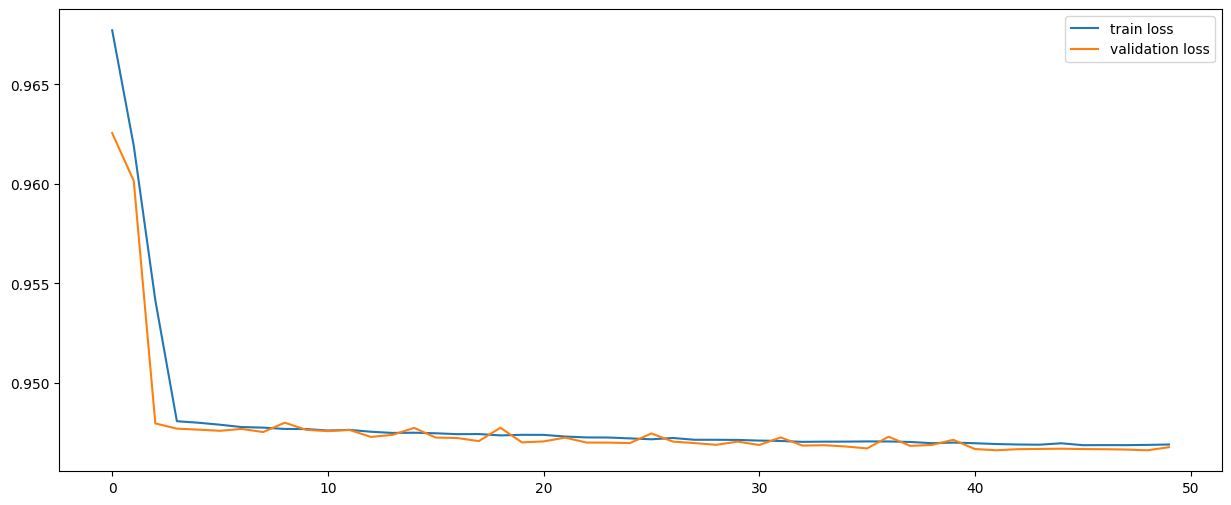

In [10]:
from models.mlp import MLP

model = MLP()
model.to(device)
model_savepoint=f"{model_checkpoint_loc}/best_val_model_{model_shortname}_mlp.pt"
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = GradientDescent(device).batch(model, criterion, optimizer,
                                    train_loader, val_loader,model_savepoint, epochs=50)
all_targets, all_predictions = GradientDescent(device).evaulate_model(model_savepoint, model, test_loader)
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))